Objectives:
- Using a bag-of-words model for movie review sentiment cassification

Bag-of-words model:
- It is a way of extracting features from text
- Each document is converted into a vector representation
- The larger the vocabulary the larger the vector size, hence smaller vocabulory is preferable.


- Split the data into train and test datasets
- 90% train, and 10% test data
- From the data of 2000 instances, last 100 positive and 100 negative are set for test dataset

### Extract the vocabulory from all the reviews and pool them into a single vector

In [1]:
from os import listdir
import re
import string
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame


# load the text from a file
def load_text_file(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_text_file_dir(dirname):
    for filename in listdir(dirname):
        #print(filename)
        if not filename.endswith(".txt"):
            next
        text = load_text_file(dirname+'//'+filename)
        #print(text)
        
def clean_text(text):
    
    # split into words by white space
    words = text.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # remove punctuation from each word
    words = [re_punc.sub('', word) for word in words]

    # remove remaining words that are not alphabetic
    words = [word for word in words if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # filter out short words
    words = [word for word in words if len(word) > 1]
    return words

def add_file_to_vocab_dict(filename, vdict):
    text = load_text_file(filename)
    words = clean_text(text)
    vdict.update(words)

# do not process the data from test files that are started with 'cv9'
def collect_vocab_from_all_files(dirname, vdict):
    for filename in listdir(dirname):
        if not filename.startswith("cv9"):
            add_file_to_vocab_dict(dirname+'\\'+filename, vdict)

def trim_vocab(vdict, min_occurance=5):
    words = [w for w,c in vdict.items() if c >= min_occurance]
    return words

def save_vocab_list(dirname, filename, vocab):
    # save vocab list into a file
    total_vocab = '\n'.join(vocab)
    with open(dirname+'\\'+filename, 'w') as file:
        file.write(total_vocab)


In [2]:
vdict = Counter()
dirname1 = r'C:\Users\Pureti\Documents\PythonDB\Machine Learning\nlp\movie reviews data\movie_reviews\txt_data\neg'
dirname2 = r'C:\Users\Pureti\Documents\PythonDB\Machine Learning\nlp\movie reviews data\movie_reviews\txt_data\pos'

dirname3 = r'C:\Users\Pureti\Documents\PythonDB\Machine Learning\nlp\movie reviews data\movie_reviews\txt_data'

collect_vocab_from_all_files(dirname1, vdict)
collect_vocab_from_all_files(dirname2, vdict)
vocab = trim_vocab(vdict, min_occurance=3)

save_vocab_list(dirname3, 'vocab_list_bow.txt', vocab)
print(len(vocab))
print(vocab[:100])

19604
['plot', 'two', 'teen', 'couples', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guys', 'dies', 'girlfriend', 'continues', 'see', 'life', 'nightmares', 'whats', 'deal', 'watch', 'movie', 'sorta', 'find', 'critique', 'mindfuck', 'generation', 'touches', 'cool', 'idea', 'presents', 'bad', 'package', 'makes', 'review', 'even', 'harder', 'write', 'since', 'generally', 'applaud', 'films', 'attempt', 'break', 'mold', 'mess', 'head', 'lost', 'highway', 'memento', 'good', 'ways', 'making', 'types', 'folks', 'didnt', 'correctly', 'seem', 'taken', 'pretty', 'neat', 'concept', 'executed', 'terribly', 'problems', 'well', 'main', 'problem', 'simply', 'jumbled', 'starts', 'normal', 'fantasy', 'world', 'audience', 'member', 'going', 'dreams', 'characters', 'coming', 'back', 'dead', 'others', 'look', 'like', 'strange', 'apparitions', 'disappearances', 'chase', 'scenes', 'tons', 'weird', 'things', 'happen', 'explained', 'personally', 'dont', 'mind', 'trying']


### A bag-of-words model
- A bag-of-words model to extract features from text so the text input can be used in machine learning.
- Each document can be converted into a vector representation.
- The length of the vector depends on the number of words in the vocabulory.

#### Load the file, clean and return the line of tokens

In [3]:
# vocab is the vector that contains all the vocabs from all the files that are from training data sets
def file_to_line_based_on_vocab(filename, vocab):
    text = load_text_file(filename)
    words = clean_text(text)
    words = [word for word in words if word in vocab]
    return ' '.join(words)

def process_all_files_based_on_vocab(dirname, vocab, is_train):
    lines = list()

    for filename in listdir(dirname):
        if (not filename.startswith("cv9")) and (is_train):
            path = dirname+'\\'+filename
            line = file_to_line_based_on_vocab(path, vocab)
            lines.append(line)
        if (filename.startswith("cv9")) and (not is_train):
            path = dirname+'\\'+filename
            line = file_to_line_based_on_vocab(path, vocab)
            lines.append(line)
    return lines



def create_clean_dataset(vocab, is_train):
    neg = process_all_files_based_on_vocab(dirname1, vocab, is_train)
    pos = process_all_files_based_on_vocab(dirname2, vocab, is_train)
    total = neg + pos

    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return total, labels

In [4]:
vocab = load_text_file(dirname3+'\\'+'vocab_list_bow.txt')
vocab = vocab.split()
vocab = set(vocab)

X_train, y_train = create_clean_dataset(vocab, True)
X_test, y_test = create_clean_dataset(vocab, False)

y_train = np.array(y_train)
y_test = np.array(y_test)
print(f'X_train: {len(X_train)}; X_test: {len(X_test)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}')

X_train: 1802; X_test: 200
y_train: 1802; y_test: 200


### Movie reviews to Bag-of-vectors
- Use Keras API to convert reviews to encoded document vectors.
- Tokenizer class is convenient and will easily transform documents into encoded vectors

In [5]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [6]:
# fit the tokenizer to train data 
tokenizer = create_tokenizer(X_train)

# encoding the data
Xtrain = tokenizer.texts_to_matrix(X_train, mode='freq')
Xtest = tokenizer.texts_to_matrix(X_test, mode='freq')

In [7]:
print(Xtrain.shape, Xtest.shape)

(1802, 19605) (200, 19605)


### Implementation of MLP models to classify encoded documents as either positive or negative
- Sentiment analysis model
- Comparing word scoring modes
- Making a prediction for the new reviews


#### Sentiment Analysis model

In [8]:
def sam_model(n_words):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                980300    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
57/57 - 11s - loss: 0.6913 - accuracy: 0.5844
Epoch 2/10
57/57 - 0s - loss: 0.6814 - accuracy: 0.7736
Epoch 3/10
57/57 - 0s - loss: 0.6651 - accuracy: 0.8368
Epoch 4/10
57/57 - 0s - loss: 0.6400 - accuracy: 0.8435
Epoch 5/10
57/57 - 0s - loss: 0.6077 - accuracy: 0.9151
Epoch 6/10
57/57 - 0s - loss: 0.5697 - accuracy: 0.9351
Epoch 7/10
57/57 - 0s - loss: 0.5293 - accuracy: 0.9412
Epoch 8/10
57/57 - 0s - loss: 0.4887 - accuracy: 0.9362
Epoch 9/10
57/57 - 0s - loss: 0.4473 - accuracy: 0.9506
Epoch 1

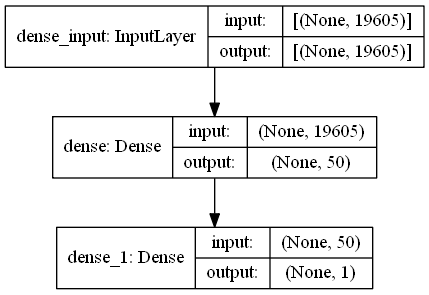

In [9]:
n_words = Xtest.shape[1]
model = sam_model(n_words)
model.fit(Xtrain, y_train, epochs=10, verbose=2)
loss, accuracy = model.evaluate(Xtest, y_test, verbose=0)
print(f'Test accuracy: {accuracy*100} %')
plot_model(model, to_file='model.png', show_shapes=True)

From the above data:
- The model easily fits the training data within the 10 epochs, and acheives 95% acuracy
- On test data, it is around 87%

## Compare word scoring methods

From Tokenizer API, there are ways to represent the encoding
- binary - Whether the vocab words present(1) or not (0) in each review
- count  - Occurance count for each word (integer)
- tfidf  - the words that are common across all documents are penalized
- freq  - the number of occurances/total words within the document


#### Prepare data

In [10]:
def prepare_data_based_on_mode(train_docs, test_docs, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_docs)
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    Xtest  = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

#### Evaluate the model based on mode

In [11]:
def mode_evaluation(Xtrain, ytrain, Xtest, ytest, n_repeats = 5):
    scores = list()
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        model = sam_model(n_words)
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        _, accuracy = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(accuracy)
        print(f'{i+1} accuracy: {accuracy}')
    return scores

In [12]:
vocab = load_text_file(dirname3+'\\'+'vocab_list_bow.txt')
vocab = vocab.split()
vocab = set(vocab)

X_train, y_train = create_clean_dataset(vocab, True)
X_test, y_test = create_clean_dataset(vocab, False)

y_train = np.array(y_train)
y_test = np.array(y_test)
print(f'X_train: {len(X_train)}; X_test: {len(X_test)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}')

modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()

for mode in modes:
    Xtrain, Xtest = prepare_data_based_on_mode(X_train, X_test, mode)
    results[mode] = mode_evaluation(Xtrain, y_train, Xtest, y_test)
print(results)
print(results.describe())

X_train: 1802; X_test: 200
y_train: 1802; y_test: 200
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                980300    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.9300000071525574
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                980300    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
_

3 accuracy: 0.875
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 50)                980300    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
_________________________________________________________________
4 accuracy: 0.8650000095367432
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 50)                980300    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
___________________________________

<AxesSubplot:>

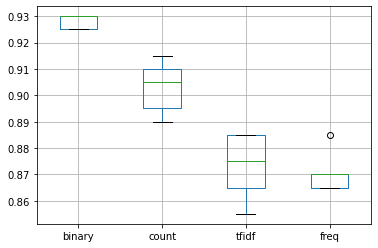

In [13]:
results.boxplot()

Binary mode (93%) is providing with more accuracy than the other modes.

In [14]:
# classify a review as negative or positive
def sentiment_prediction(review, vocab, tokenizer, model):
    words = clean_text(review)
    
    # filter by vocab
    words = [w for w in words if w in vocab]
    
    # convert to line
    line = ' '.join(words)
    
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    
    # predict sentiment
    y_predict = model.predict(encoded, verbose=0)
    
    # retrieve predicted percentage and label
    percent_pos = y_predict[0,0]
    
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [16]:
# test case 1: positive text
text = 'Best movie! It was a great movie, I recommend it.'
percent, sentiment = sentiment_prediction(text, vocab, tokenizer, model)
print(f'Review: {text}\nSentiment: {sentiment} {round(percent*100, 2)}%' )

# test case 2: negative text
text = 'bad movie ever! It was not a great movie.'
percent, sentiment = sentiment_prediction(text, vocab, tokenizer, model)
print(f'Review: {text}\nSentiment: {sentiment} {round(percent*100, 2)}%' )

Review: Best movie! It was a great movie, I recommend it.
Sentiment: POSITIVE 99.32%
Review: bad movie ever! It was not a great movie.
Sentiment: NEGATIVE 98.87%
